In [25]:
from datetime import datetime
import pandas as pd 
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt;
import itertools
from scipy.optimize import minimize,LinearConstraint

instruments = [
# 'SPY-STK-ARCA',
# 'SHY-STK-ARCA',
# 'HYG-STK-ARCA',
# 'IEF-STK-ARCA',
# 'TIP-STK-ARCA',
# 'GLD-STK-ARCA',
# 'VNQ-STK-ARCA',
 'XLB-STK-ARCA',
 'XLE-STK-ARCA',
 'XLF-STK-ARCA',
 'XLI-STK-ARCA',
 'XLK-STK-ARCA',
 'XLP-STK-ARCA',
 'XLU-STK-ARCA',
 'XLV-STK-ARCA',
 'XLY-STK-ARCA',
]

In [26]:
d= {}
dfs= [pd.read_pickle("data/"+instrument+"_2010-01-01.pkl") for instrument in instruments]
df=pd.concat(dfs, axis=0).swaplevel(0,1)
d = np.vstack([df['close'][inst].values for inst in instruments] )

In [27]:
Y = np.log(d)
Y = (Y.T - Y[:,0])


In [ ]:
plt.plot(Y)

In [28]:
window = 5
C_t = []
dY = np.diff(Y,axis=0)
H = 5
r_t = []
for t in range(len(dY)):
    dY_w = dY[max(0,t-window):t,:]
    C_t.append(dY_w.T.dot(dY_w))
    r_t.append(dY[t:min(len(dY),t+H),:].mean(axis=0))
C_t = np.array(C_t)
r_t = np.vstack(r_t)

In [35]:
from sklearn.decomposition import PCA
n_comp = 7
X = C_t.reshape(len(C_t),-1)
pca = PCA(n_components=n_comp)
pca.fit(X)

PCA(n_components=7)

In [36]:
X_pca = pca.transform(X)

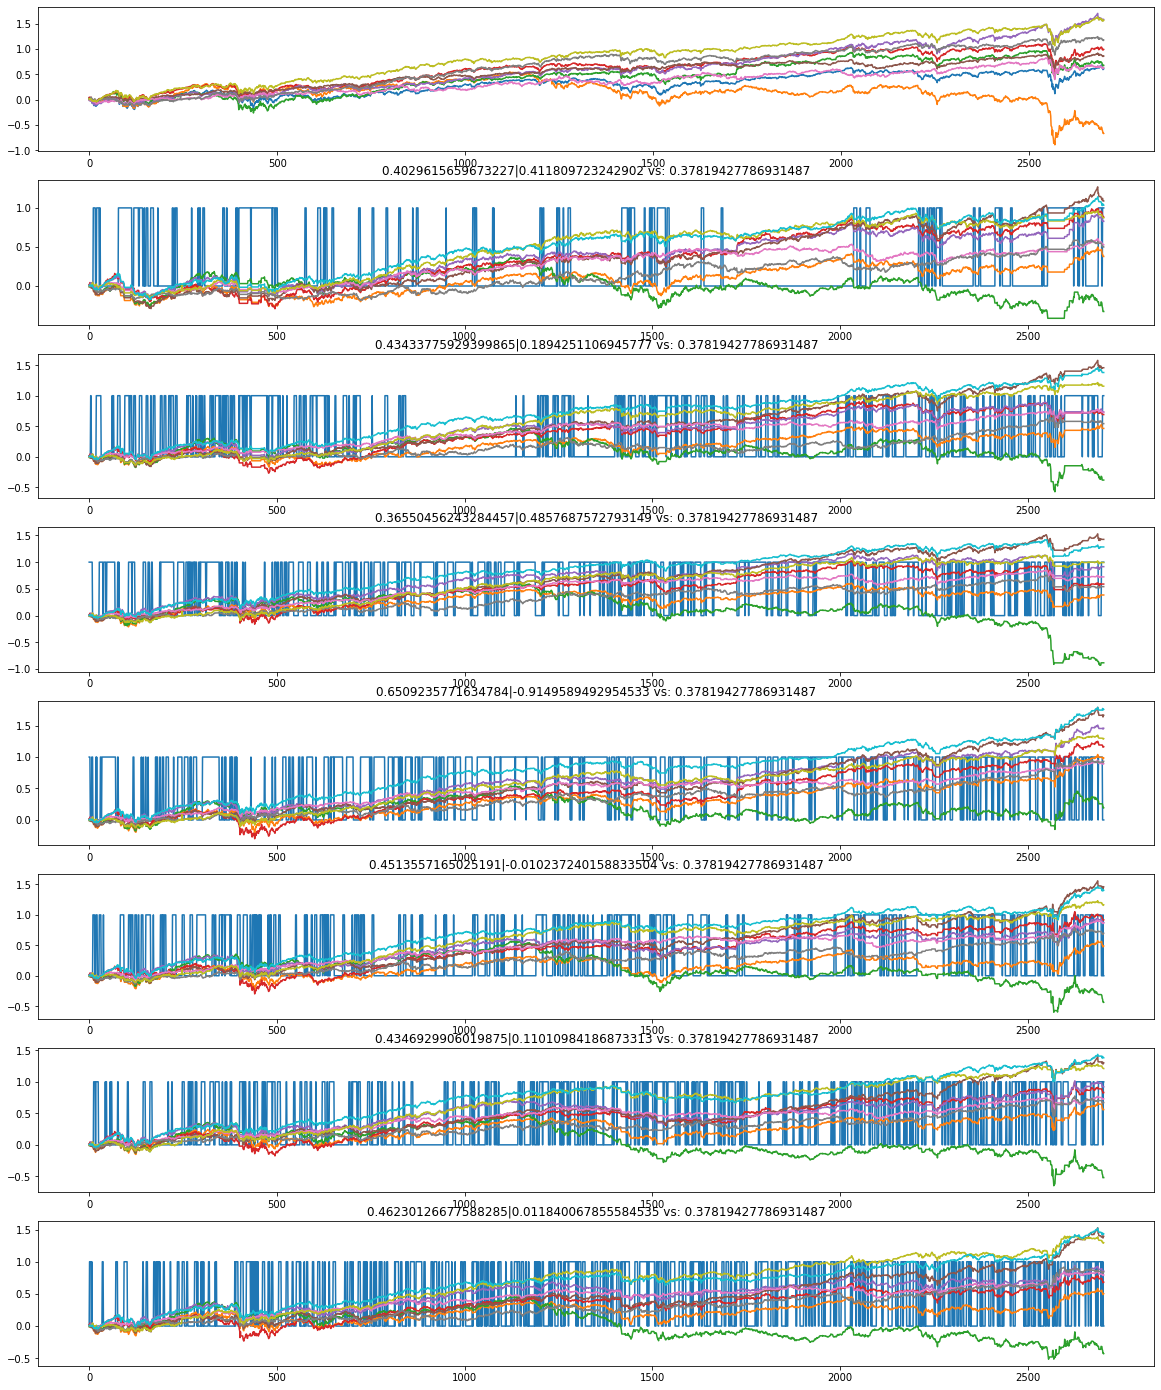

In [40]:
N = 1+n_comp
plt.figure(figsize=(20,25))
plt.subplot(N, 1, 1)
plt.plot(Y[window:])
for i in range(n_comp):
    plt.subplot(N, 1, 2+i)
    plt.plot(X_pca[:,i]>0)
    sig = (X_pca[:,i]<np.percentile(X_pca[:,i],90)).reshape(-1,1)
    s = (dY*sig)
    s_ = (dY*(1-sig))
    sharpe = lambda dd : (252**0.5)*(dd[dd!=0].mean()/dd[dd!=0].std())
    plt.title(str(sharpe(s)) + "|" + str(sharpe(s_)) + " vs: " + str(sharpe(dY.reshape(-1))))
    plt.plot(np.cumsum(s,axis=0))
    #plt.plot(np.cumsum(s_,axis=0))
plt.show()

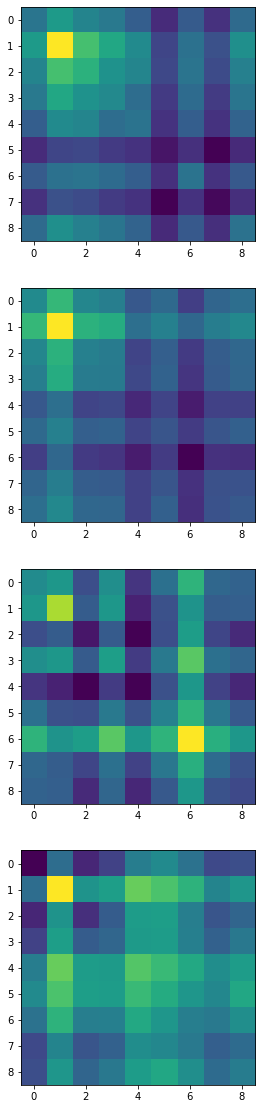

In [10]:
N = 1+n_comp
plt.figure(figsize=(20,25))
for i in range(n_comp):
    plt.subplot(N, 1, i+1)
    plt.imshow(pca.components_[i,:].reshape(dY.shape[1],dY.shape[1]))

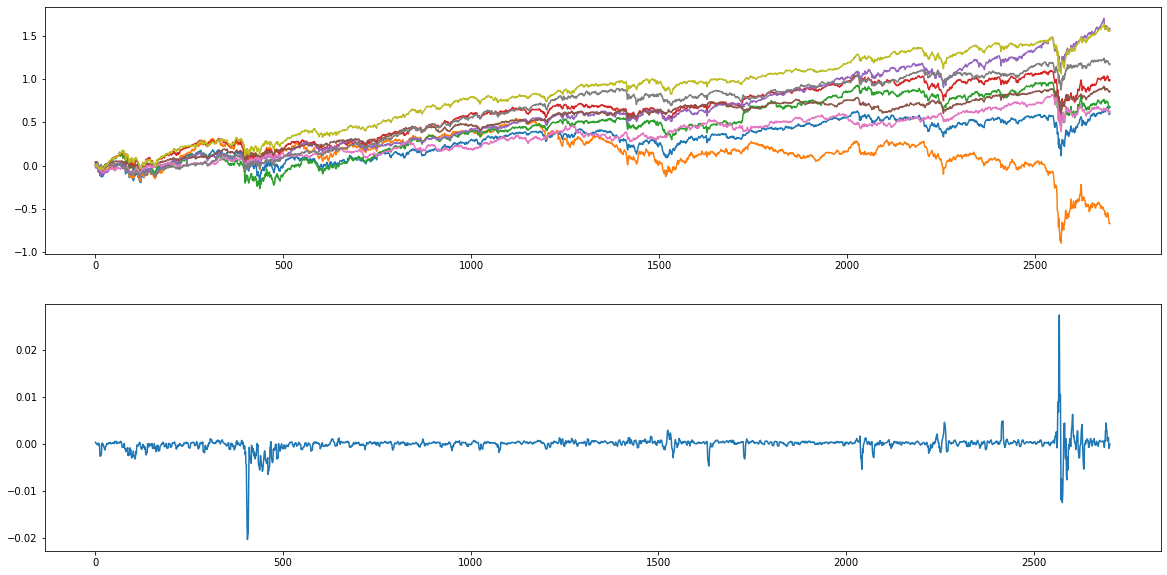

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(Y[window:])
plt.subplot(2, 1,2 )
plt.plot(X_pca[:,3])
plt.show()

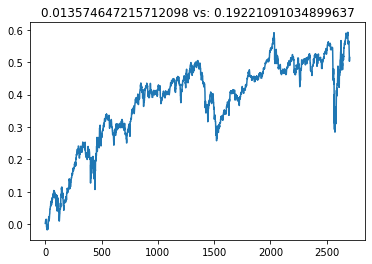

In [22]:
from sklearn.neighbors import KNeighborsRegressor

window = 5 
H = 5
n_comp = 4
n_nn = 25
t_train = int(len(dY)/2)

dY = np.diff(Y,axis=0)
C_t = []
r_t = []
for t in range(len(dY)):
    dY_w = dY[max(0,t-window):t,:]
    C_t.append(dY_w.T.dot(dY_w))
    r_t.append(dY[t:min(len(dY),t+H),:].sum(axis=0))#/dY[t:min(len(dY),t+H),:].std(axis=0))
C_t = np.array(C_t)
r_t = np.vstack(r_t)


X = C_t.reshape(len(C_t),-1)
pca = PCA(n_components=n_comp)
pca.fit(X[t_train:,:])
X_pca = 1.0*(pca.transform(X)>0)


signal = KNeighborsRegressor(n_neighbors=n_nn)
signal.fit(X_pca[:t_train,:],r_t[:t_train])#dY[:t_train,:])
signal = signal.predict(X_pca)
s = (1*(signal>0)*dY).mean(1)
plt.title(str(sharpe(s[t_train:])) + " vs: " + str(sharpe(dY[t_train:].reshape(-1))))
plt.plot(np.cumsum(s))

/home/santiago_perez_lastra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


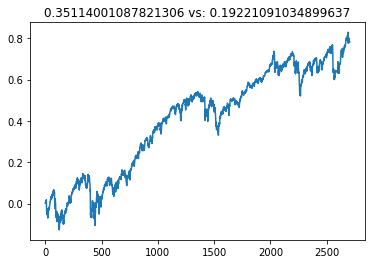

In [456]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


window = 5
H = 5
n_comp = 5
t_train = int(len(dY)/2)

dY = np.diff(Y,axis=0)
C_t = []
r_t = []
for t in range(len(dY)):
    dY_w = dY[max(0,t-window):t,:]
    C_t.append(dY_w.T.dot(dY_w))
    r_t.append(dY[t:min(len(dY),t+H),:].sum(axis=0)/dY[t:min(len(dY),t+H),:].std(axis=0))

C_t = np.array(C_t)
r_t = np.vstack(r_t)


X = C_t.reshape(len(C_t),-1)
pca = PCA(n_components=n_comp)
pca.fit(X[t_train:,:])
X_pca = pca.transform(X)


signal = LinearRegression()
signal.fit(X_pca[:t_train,:],r_t[:t_train,:])
signal = signal.predict(X_pca)
s = (1*(signal>0)*dY).mean(1)
plt.title(str(sharpe(s[t_train:])) + " vs: " + str(sharpe(dY[t_train:].reshape(-1))))
plt.plot(np.cumsum(s))